## Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torchvision import models, transforms, datasets
from tqdm import tqdm

## Importing the datasets

In [2]:
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    transforms.Resize((100,100))
])
test_transform =  transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    transforms.Resize((100,100))
])

train_set = datasets.ImageFolder(data_dir+'/Training', transform=train_transform)
test_set = datasets.ImageFolder(data_dir+'/Testing', transform=test_transform)

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size)

## Defining the Model

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
        nn.Linear(1024,460),
        nn.ReLU(),
        nn.Linear(460,4)
)
for param in model.classifier.parameters():
    param.requires_grad = True
model = model.to(device)

## defining the Loss and the optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

## Train the Model

In [10]:
Epochs = 15
train_losses = {}
train_accu = {}
test_losses = {}
test_accu = {}

for epoch in range(Epochs):
    train_loss = []
    test_loss = []
    train_acc = 0
    test_acc = 0
    
    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Epochs}")
    model.train()  # Ensure the model is in training mode
    
    for img, label in train_loader_tqdm:
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Predictions and accuracy calculation
        _, pred = torch.max(output, 1)
        train_acc += (pred == label).sum().item()  # Convert to item for compatibility
    
    # Compute average loss and accuracy for training
    train_losses[epoch] = np.mean(train_loss)
    train_accu[epoch] = 100 * train_acc / len(train_loader.dataset)  # Accuracy based on total dataset size
    
    # Update the progress bar with current train loss and accuracy
    train_loader_tqdm.set_postfix({
        'train loss': train_losses[epoch], 
        'train accuracy': train_accu[epoch]
    })
    
    # Testing loop with progress bar
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{Epochs}")
    model.eval()  # Set the model to evaluation mode (no gradient calculation)
    
    with torch.no_grad():  # No gradients during testing
        for img, label in test_loader_tqdm:
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            test_loss.append(loss.item())
            
            # Predictions and accuracy calculation
            _, pred = torch.max(output, 1)
            test_acc += (pred == label).sum().item()  # Convert to item for compatibility
    
    # Compute average loss and accuracy for testing
    test_losses[epoch] = np.mean(test_loss)
    test_accu[epoch] = 100 * test_acc / len(test_loader.dataset)  # Accuracy based on total dataset size
    
    # Update the progress bar with current test loss and accuracy
    test_loader_tqdm.set_postfix({
        'test loss': test_losses[epoch], 
        'test accuracy': test_accu[epoch]  # Corrected to 'test accuracy'
    })
    print(f'Epoch{epoch+1}/{Epochs}, Train_loss: {train_losses[epoch]}, Train_acc: {train_accu[epoch]}, Test_loss: {test_losses[epoch]}, Test_acc: {test_accu[epoch]}')



Epoch 1/15: 100%|██████████| 41/41 [00:06<00:00,  5.97it/s]


Epoch1/15, Train_loss: 0.5636685314957656, Train_acc: 80.28711484593838, Test_loss: 0.39756724667712684, Test_acc: 84.28680396643783


Epoch 2/15: 100%|██████████| 41/41 [00:06<00:00,  6.22it/s]


Epoch2/15, Train_loss: 0.37567297173611947, Train_acc: 85.97689075630252, Test_loss: 0.3391187023371458, Test_acc: 86.80396643783371


Epoch 3/15: 100%|██████████| 41/41 [00:06<00:00,  6.57it/s]


Epoch3/15, Train_loss: 0.31531993507839445, Train_acc: 87.97268907563026, Test_loss: 0.32251420173021716, Test_acc: 86.57513348588863


Epoch 4/15: 100%|██████████| 41/41 [00:06<00:00,  5.90it/s]


Epoch4/15, Train_loss: 0.2724452284711033, Train_acc: 89.8109243697479, Test_loss: 0.2900439065585776, Test_acc: 88.93974065598779


Epoch 5/15: 100%|██████████| 41/41 [00:08<00:00,  4.99it/s]


Epoch5/15, Train_loss: 0.2525027221141581, Train_acc: 91.00140056022408, Test_loss: 0.27637064593230803, Test_acc: 90.23646071700992


Epoch 6/15: 100%|██████████| 41/41 [00:06<00:00,  6.16it/s]


Epoch6/15, Train_loss: 0.2339590715462935, Train_acc: 91.29901960784314, Test_loss: 0.24645542312504315, Test_acc: 89.93135011441647


Epoch 7/15: 100%|██████████| 41/41 [00:07<00:00,  5.62it/s]


Epoch7/15, Train_loss: 0.20726937885973706, Train_acc: 92.24439775910363, Test_loss: 0.25690955811793487, Test_acc: 90.99923722349352


Epoch 8/15: 100%|██████████| 41/41 [00:06<00:00,  6.01it/s]


Epoch8/15, Train_loss: 0.1935602461492549, Train_acc: 93.11974789915966, Test_loss: 0.24000144496037648, Test_acc: 91.15179252479024


Epoch 9/15: 100%|██████████| 41/41 [00:06<00:00,  6.34it/s]


Epoch9/15, Train_loss: 0.1749723816092787, Train_acc: 93.99509803921569, Test_loss: 0.19408674270664228, Test_acc: 92.52479023646072


Epoch 10/15: 100%|██████████| 41/41 [00:07<00:00,  5.76it/s]


Epoch10/15, Train_loss: 0.1771113448229998, Train_acc: 93.5749299719888, Test_loss: 0.23701081315350786, Test_acc: 90.99923722349352


Epoch 11/15: 100%|██████████| 41/41 [00:06<00:00,  6.39it/s]


Epoch11/15, Train_loss: 0.14541570081599264, Train_acc: 95.0280112044818, Test_loss: 0.17382596837492978, Test_acc: 93.44012204424104


Epoch 12/15: 100%|██████████| 41/41 [00:07<00:00,  5.77it/s]


Epoch12/15, Train_loss: 0.1361061201519307, Train_acc: 95.01050420168067, Test_loss: 0.1613100243153096, Test_acc: 93.66895499618612


Epoch 13/15: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]


Epoch13/15, Train_loss: 0.12471796620075264, Train_acc: 95.50070028011204, Test_loss: 0.1491006730612731, Test_acc: 94.88939740655988


Epoch 14/15: 100%|██████████| 41/41 [00:07<00:00,  5.79it/s]


Epoch14/15, Train_loss: 0.1104500905803129, Train_acc: 96.39355742296918, Test_loss: 0.1379440331394307, Test_acc: 95.57589626239512


Epoch 15/15: 100%|██████████| 41/41 [00:05<00:00,  7.06it/s]

Epoch15/15, Train_loss: 0.10523508442305653, Train_acc: 96.2359943977591, Test_loss: 0.152821209838205, Test_acc: 94.43173150266972


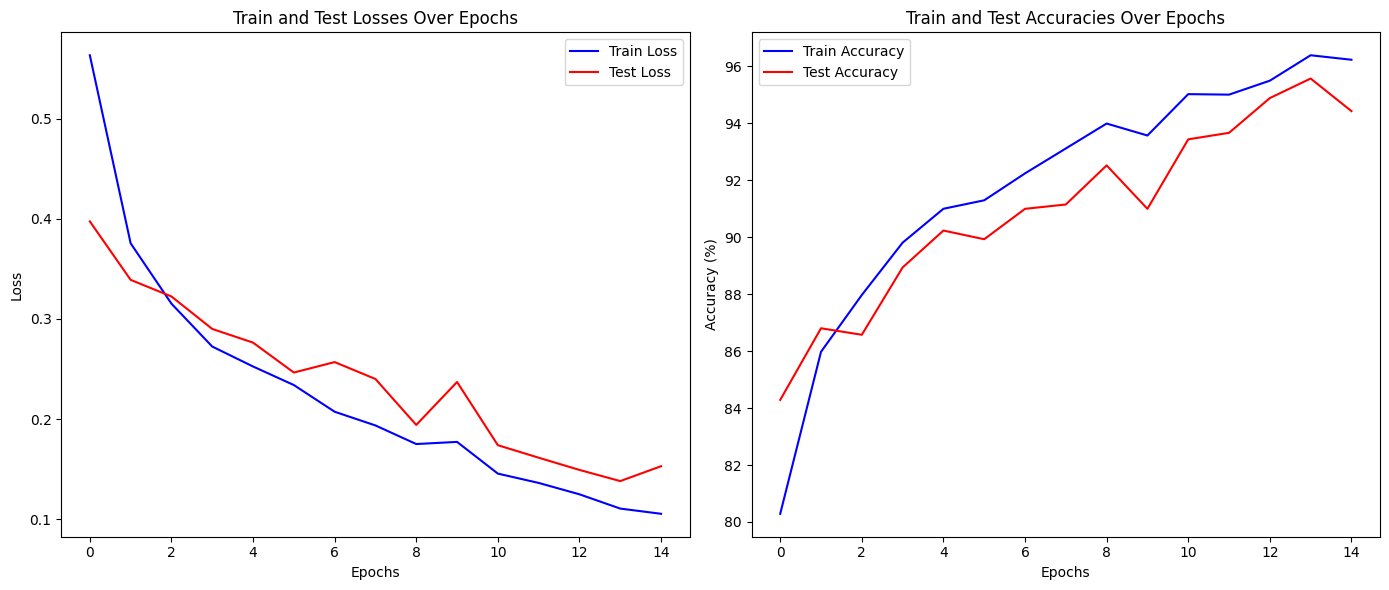

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Losses (Left subplot)
ax1.plot(train_losses.values(), 'b', label='Train Loss')
ax1.plot(test_losses.values(), 'r', label='Test Loss')
ax1.set_title('Train and Test Losses Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting Accuracies (Right subplot)
ax2.plot(train_accu.values(), 'b', label='Train Accuracy')
ax2.plot(test_accu.values(), 'r', label='Test Accuracy')
ax2.set_title('Train and Test Accuracies Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()